# MRS wavelength calibration reference point determination
Script written by Ioannis Argyriou (Institute of Astronomy, KU Leuven), with updates from Alvaro Labiano (CAB)  
Creation date 7th October 2018  

### > Import modules

In [1]:
import funcs
from distortionMaps import d2cMapping

import os
import glob
import numpy as np
from astropy.io import fits
from datetime import date
import matplotlib.pyplot as plt

%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

### > Set directories

In [14]:
# USER:
user = "yannis" # "yannis"

# Set work directory
# *** Change these to more general folders like"./data_for_notebook_test/" that we can all have
if user == "alvaro":
    workDir = "./"
    
if user == "yannis":
    workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"

cdpDir   = workDir+"cdp_data/CDP8/"
mirisim_path = '/Users/ioannisa/Desktop/python/mirisim/'

### > Give analysis inputs

In [9]:
# inputs
band = '1A'                     # spectral band under investigation
islice    = 10                  # slice number (equivalent to beta position)
alpha_pos = 0.                  # along-slice position, [arcsec]

## Start analysis

A reference wavelength/pixel pair is determined using the long-wave-pass (SWP) filter transmission. By comparing the transmission of the filter determined from the lab and with the MRS, a reference wavelength can be matched to a reference pixel on the MRS detector. Let's look at the lab and MRS SWP filter transmission.

During commissioning the reference point will be obtained from the spectral lines of a celestial calibrator.

### > Import PNe absolutely calibrated spectrum

<IPython.core.display.Javascript object>


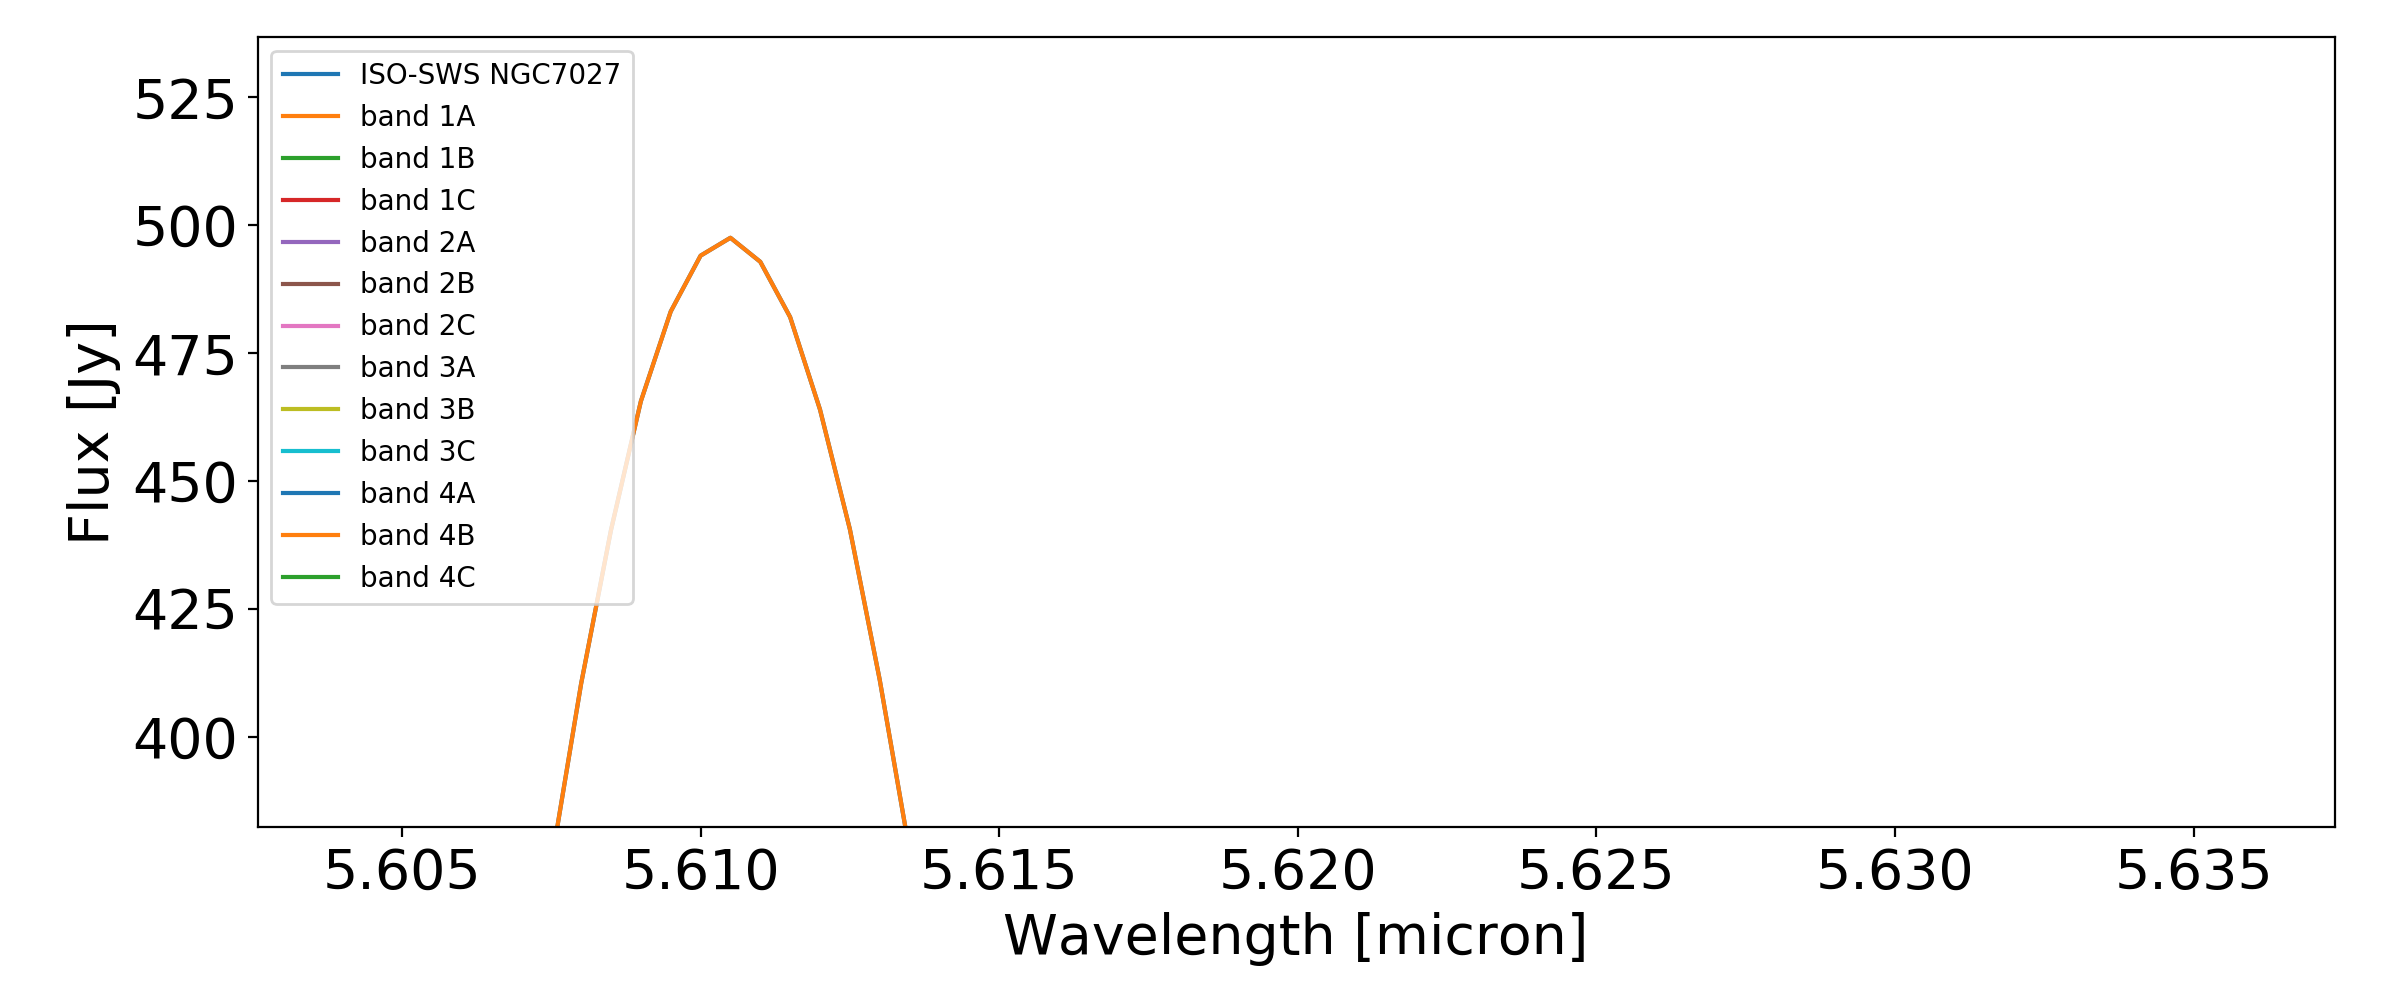

In [5]:
dataDir = "/Users/ioannisa/Desktop/python/miri_devel/notebooks/ISOSWS_PlanetaryNebulae/PNe_data/"
hdulist = fits.open(dataDir + "55800537_sws.fit")

wavl,spec = hdulist[0].data[:,0], hdulist[0].data[:,1]
sel = (wavl>4.8) & (wavl<28.8)
wavl,spec = wavl[sel],spec[sel]

# plot transmissions
plt.figure(figsize=(12,5))
plt.plot(wavl,spec,label="ISO-SWS NGC7027")
for iband in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    sel_wavl = (wavl>=funcs.mrs_aux(iband)[3][0]) & (wavl<=funcs.mrs_aux(iband)[3][1])
    plt.plot(wavl[sel_wavl],spec[sel_wavl],label="band {}".format(iband))
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('Flux [Jy]',fontsize=20)
plt.legend(loc='upper left',fontsize=10)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

## > Import MRS observations of filter

In [10]:
# Lets examine the results.
source_dir = glob.glob(mirisim_path+'NGC7027_band{}_*_mirisim_*'.format(band))[0]
source_imgfile = glob.glob(source_dir+'/det_images/det_image_seq*_MIRIFU{}_{}{}exp*.fits'.format(funcs.band_to_det(band),funcs.band_to_channel(band),funcs.band_to_subband(band)))[0]

print source_imgfile

/Users/ioannisa/Desktop/python/mirisim/NGC7027_band1A_0dither_fast_1int_10frames_mirisim_20190121_162850/det_images/det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits


In [11]:
source_hdu = fits.open(source_imgfile)
source_img = source_hdu[1].data
mrs_channel = source_hdu[0].header['CHANNEL']

nints = source_hdu[0].header['NINTS']
ngroups = source_hdu[0].header['NGROUPS']
frame_delta_time = source_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('LVL1 data shape: {}'.format(source_hdu[1].data.shape))

Number of integrations: 1
Number of groups/frames per integration: 10
LVL1 data shape: (1, 10, 1024, 1032)


<IPython.core.display.Javascript object>


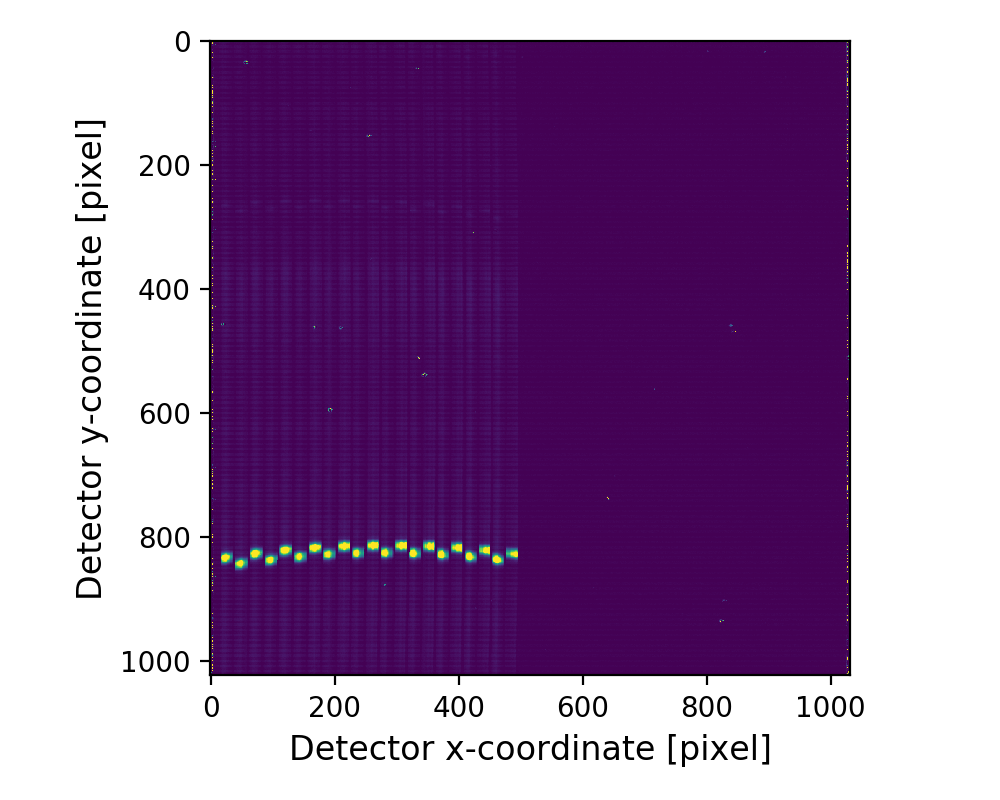

<IPython.core.display.Javascript object>


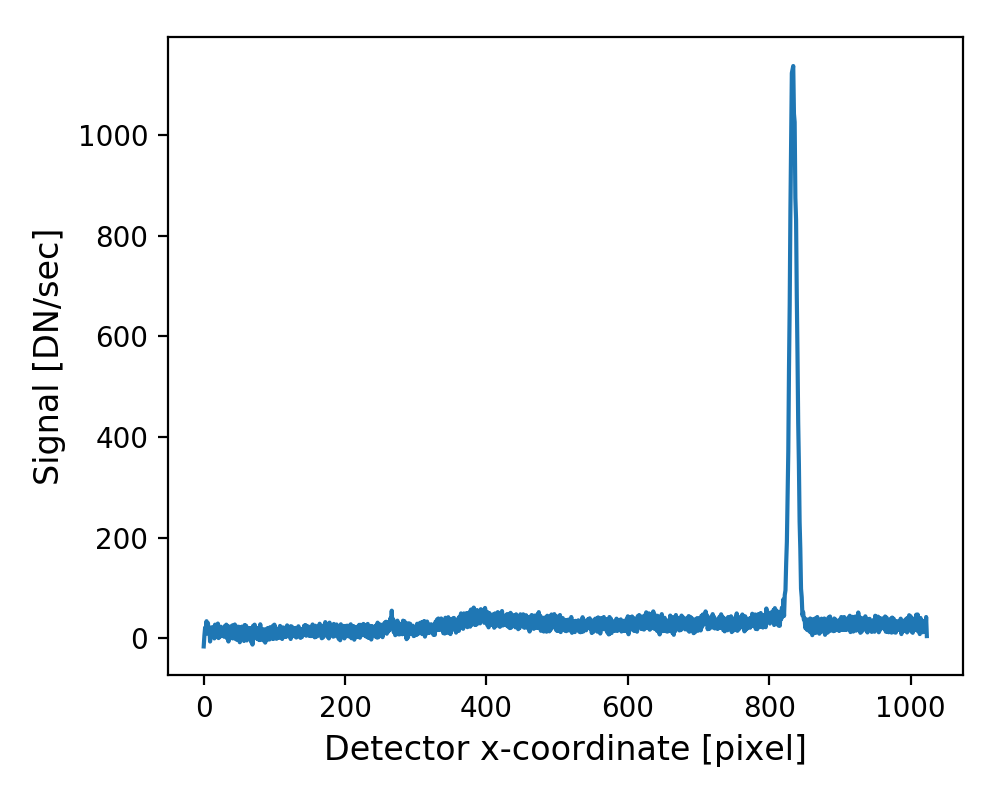

<IPython.core.display.Javascript object>


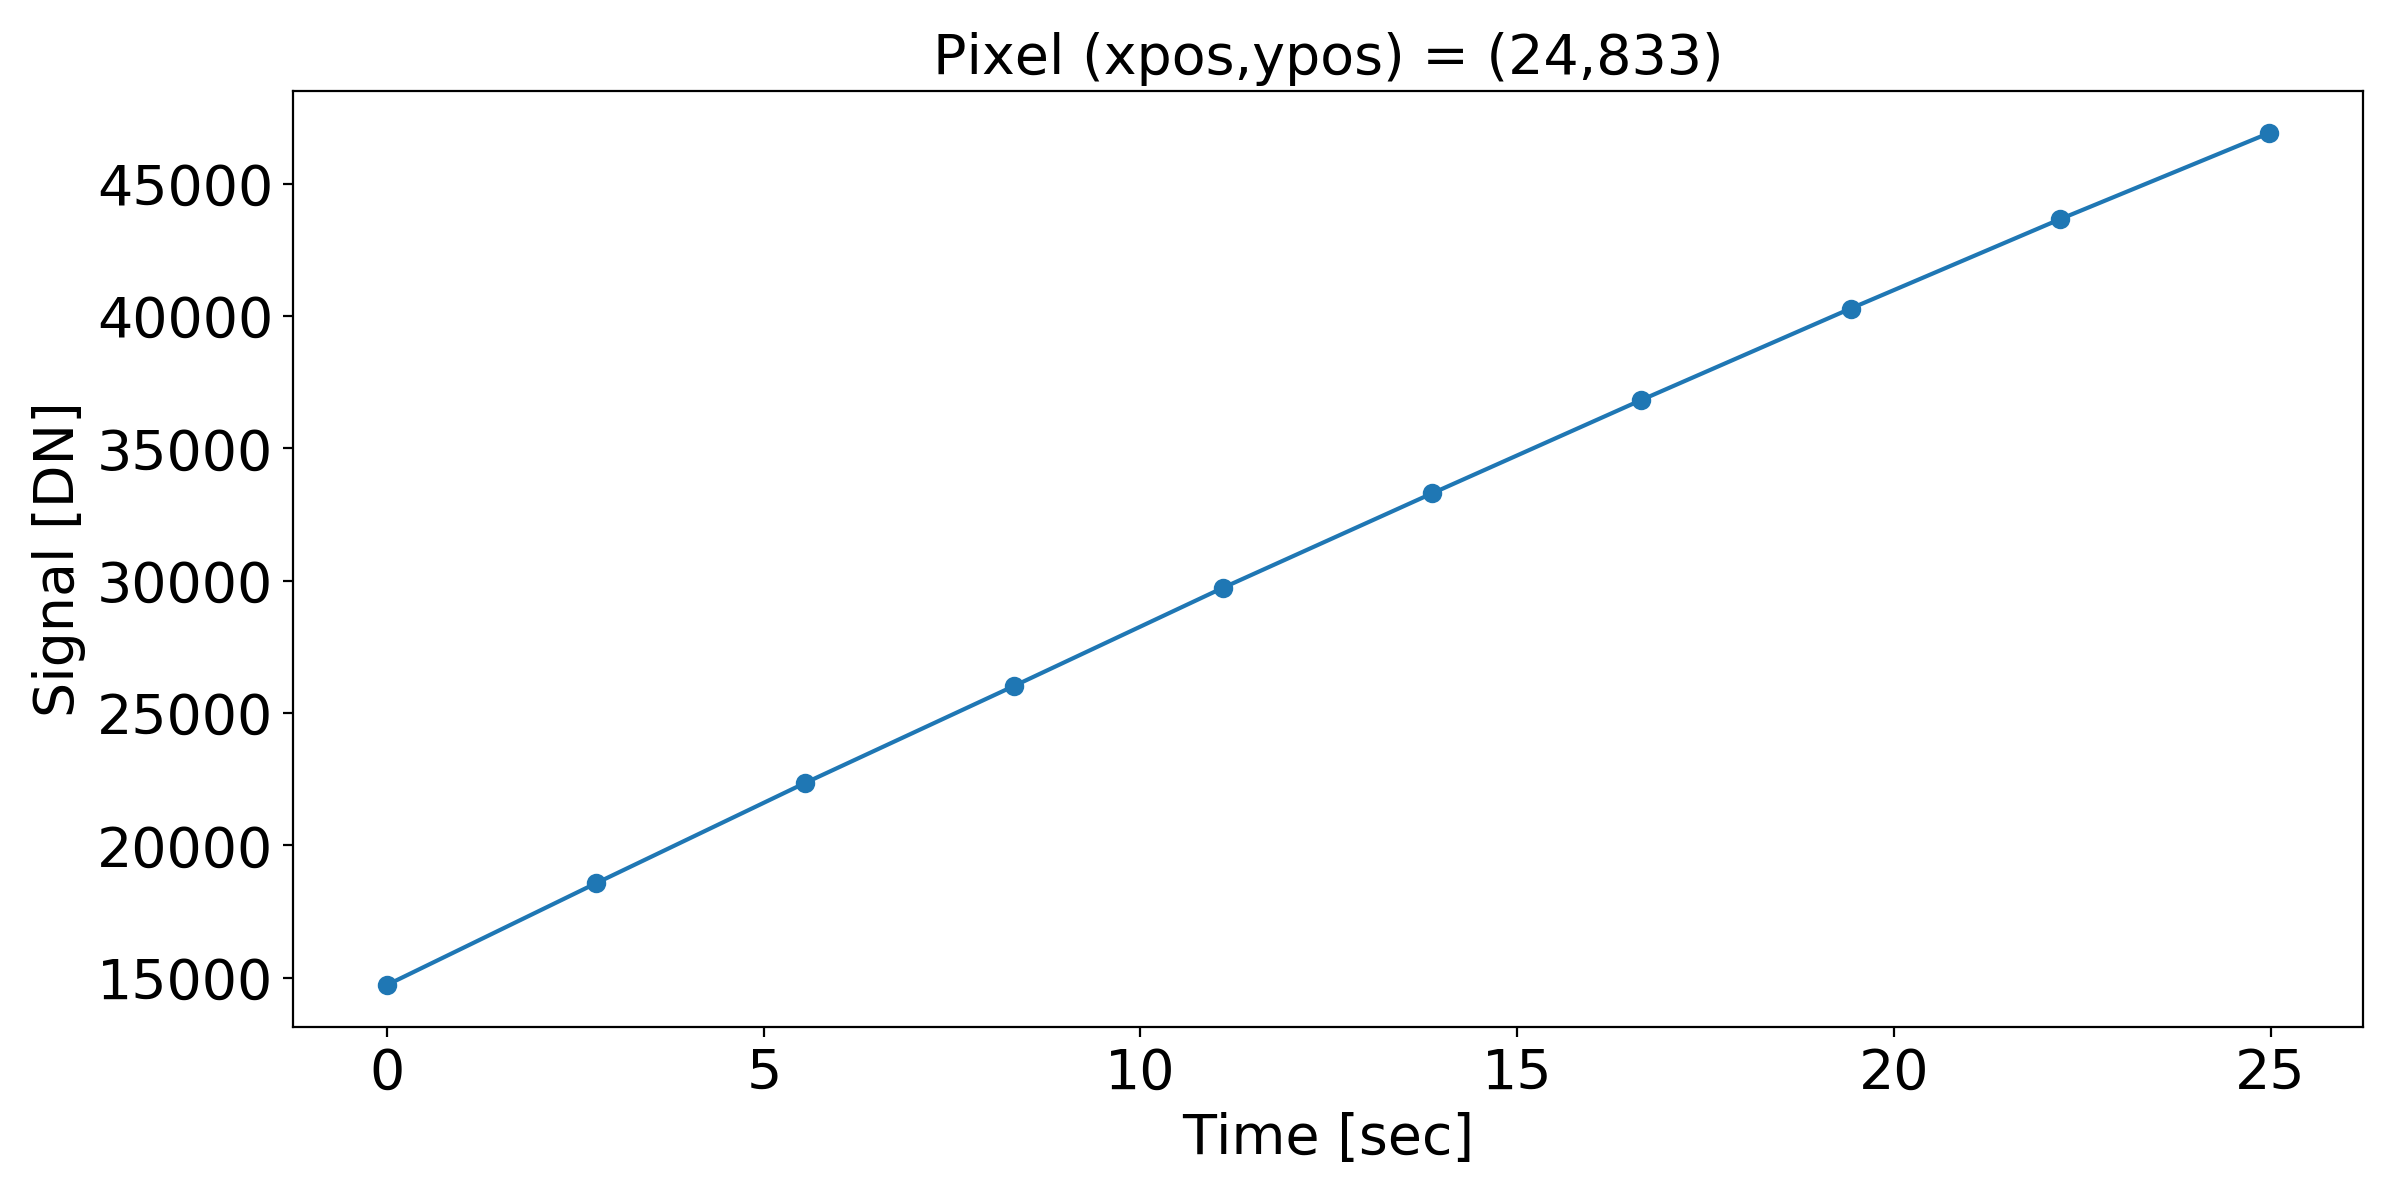

In [25]:
source_slope = (source_img[0,1,:,:]-source_img[0,0,:,:])/frame_delta_time
if mrs_channel == '34':
    # The wavecal analysis of channels 3 and 4 will be inverted; 
    # this is to by-pass the issue that the lambdaMap of channel 3 and 4 are in fact inverted (pix0->1024 yields decreasing wavelengths, as opposed to channels 1 and 2 that yield increasing wavelengths)
    source_slope = np.flipud(source_slope)

# plot
plt.figure(figsize=(5,4))
plt.imshow(source_slope,vmin=0,vmax=source_slope.max()/10.)
plt.xlabel('Detector x-coordinate [pixel]',fontsize=12)
plt.ylabel('Detector y-coordinate [pixel]',fontsize=12)
plt.tight_layout()

plt.figure(figsize=(5,4))
plt.plot(source_slope[:,27])
plt.xlabel('Detector x-coordinate [pixel]',fontsize=12)
plt.ylabel('Signal [DN/sec]',fontsize=12)
plt.tight_layout()

if band[0] in ['1','4']: ypos,xpos = 833,24
elif band[0] in ['2','3']: ypos,xpos = 623,671

plt.figure(figsize=(12,6))
for i in range(nints):
    xdata  = np.arange(ngroups)*frame_delta_time+i*frame_delta_time*(ngroups-1)
    ydata  = source_img[i,:,ypos,xpos]
    
    plt.scatter(xdata,ydata)
    plt.plot(xdata,ydata)
plt.title('Pixel (xpos,ypos) = ({},{})'.format(xpos,ypos),fontsize=20)
plt.xlabel('Time [sec]',fontsize=20)
plt.ylabel('Signal [DN]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

## > Perform wavelength calibration analysis on selected position

In [15]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir,fileversion = "8B.05.00")
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

if band[0] in ['3','4']:
    sliceMap  = np.flipud(sliceMap)
    lambdaMap = np.flipud(lambdaMap)
    alphaMap  = np.flipud(alphaMap)

<IPython.core.display.Javascript object>


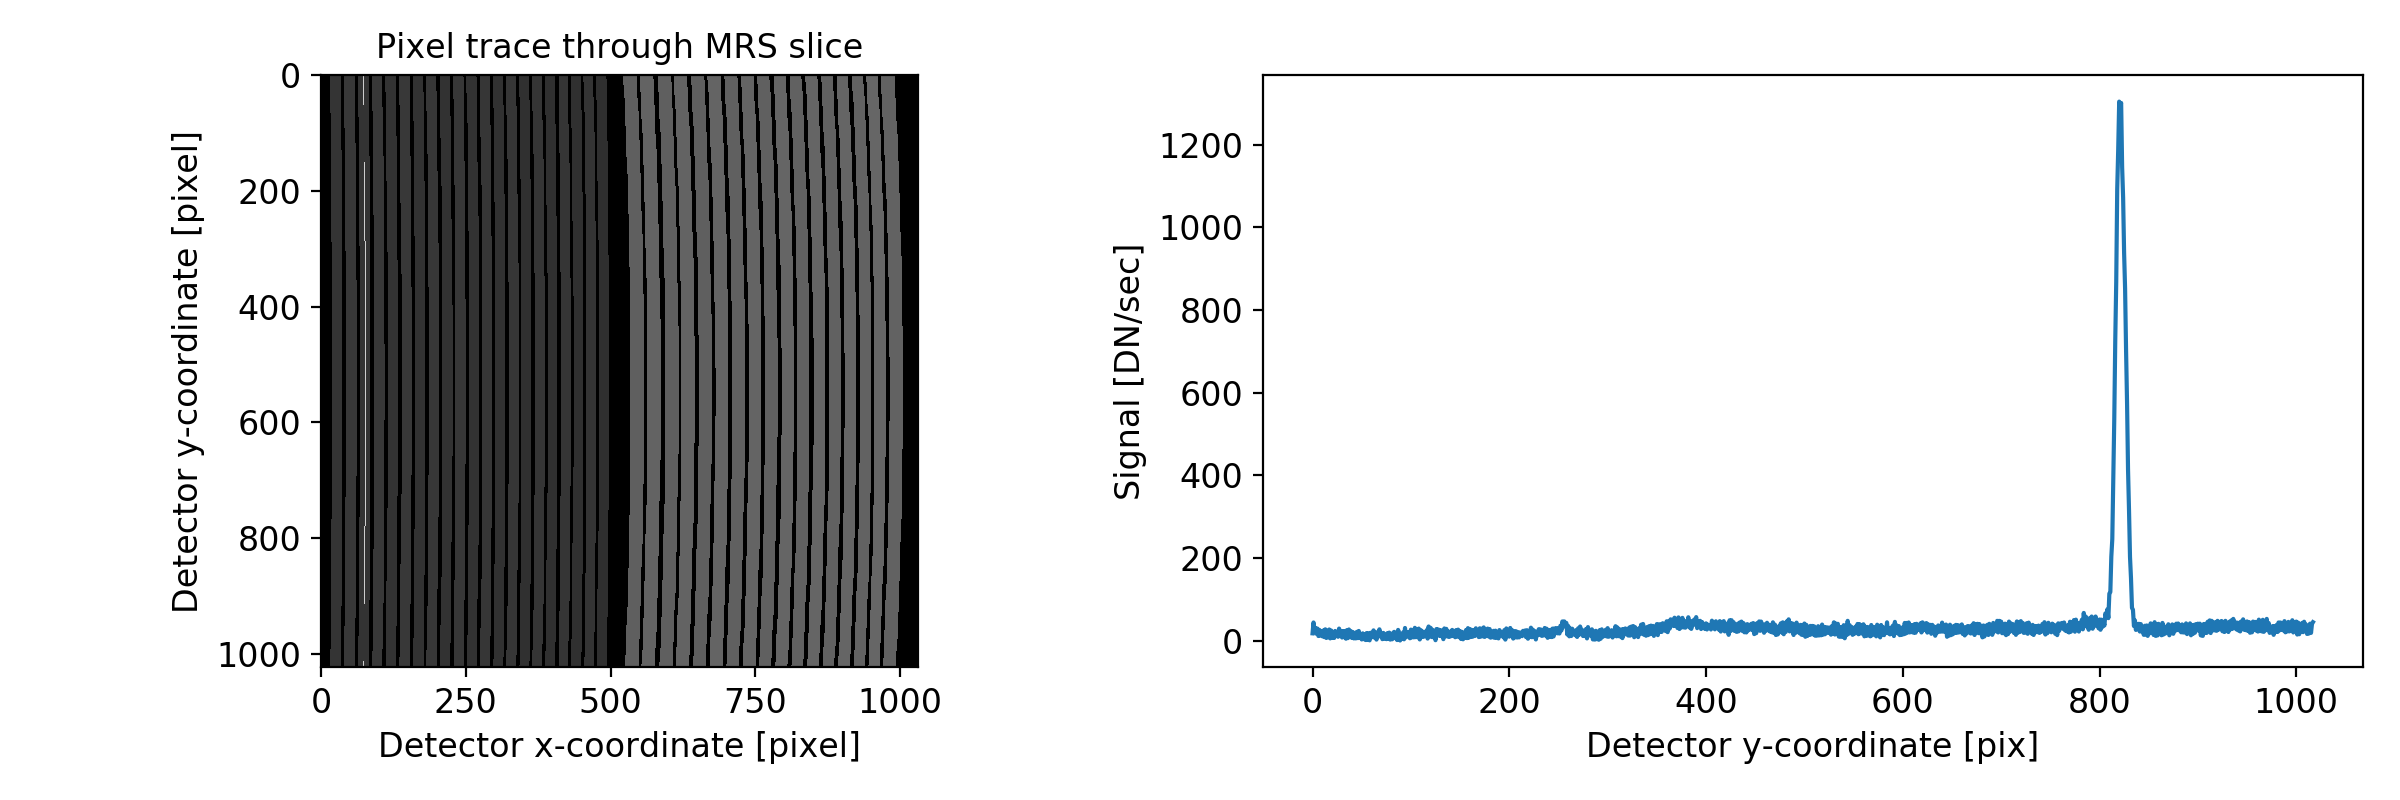

In [27]:
# take pixel trace along specified slice, specified alpha position
## ******* AL: Shall we use interpolation between closest alpha values? <-- This should result in a pixel to sub-pixel order improvement on the determination of the wavelength-pixel reference
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=alpha_pos)

# plot trace
valid_img = np.zeros(det_dims)
valid_img[ypos,xpos] = 1.

fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].imshow(sliceMap,cmap='gray')
axs[0].imshow(valid_img,alpha=0.6,cmap='gray')
axs[0].set_title('Pixel trace through MRS slice',fontsize=12)
axs[0].set_xlabel('Detector x-coordinate [pixel]',fontsize=12)
axs[0].set_ylabel('Detector y-coordinate [pixel]',fontsize=12)
axs[1].plot(source_slope[ypos,xpos][source_slope[ypos,xpos]>0])
# axs[1].set_title('{} filter transmission (MRS data)'.format(usedfilter),fontsize=12)
axs[1].set_xlabel('Detector y-coordinate [pix]',fontsize=12)
axs[1].set_ylabel('Signal [DN/sec]',fontsize=12)
for plot in range(2): axs[plot].tick_params(axis='both',labelsize=12)
plt.tight_layout()

### > Yannis fit of the reference point
The result of the following analysis is the definition of a reference wavelength/pixel pair.

<IPython.core.display.Javascript object>


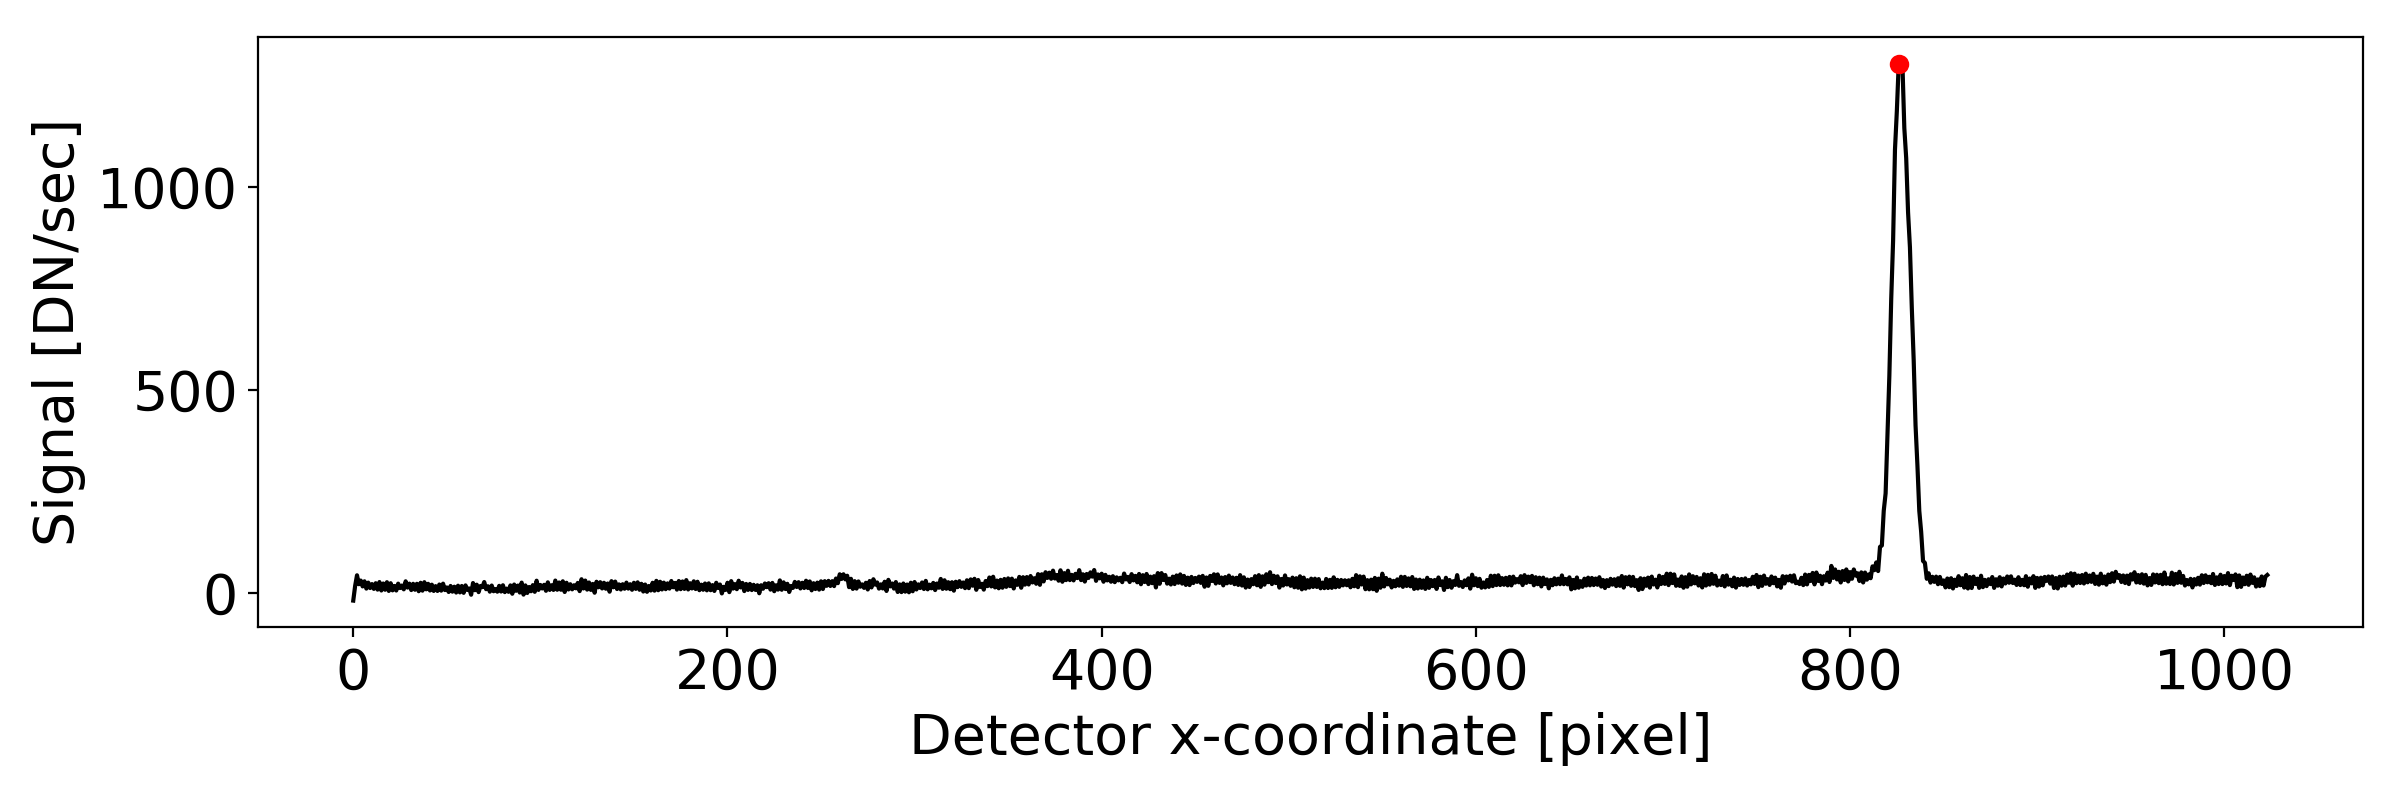

<IPython.core.display.Javascript object>


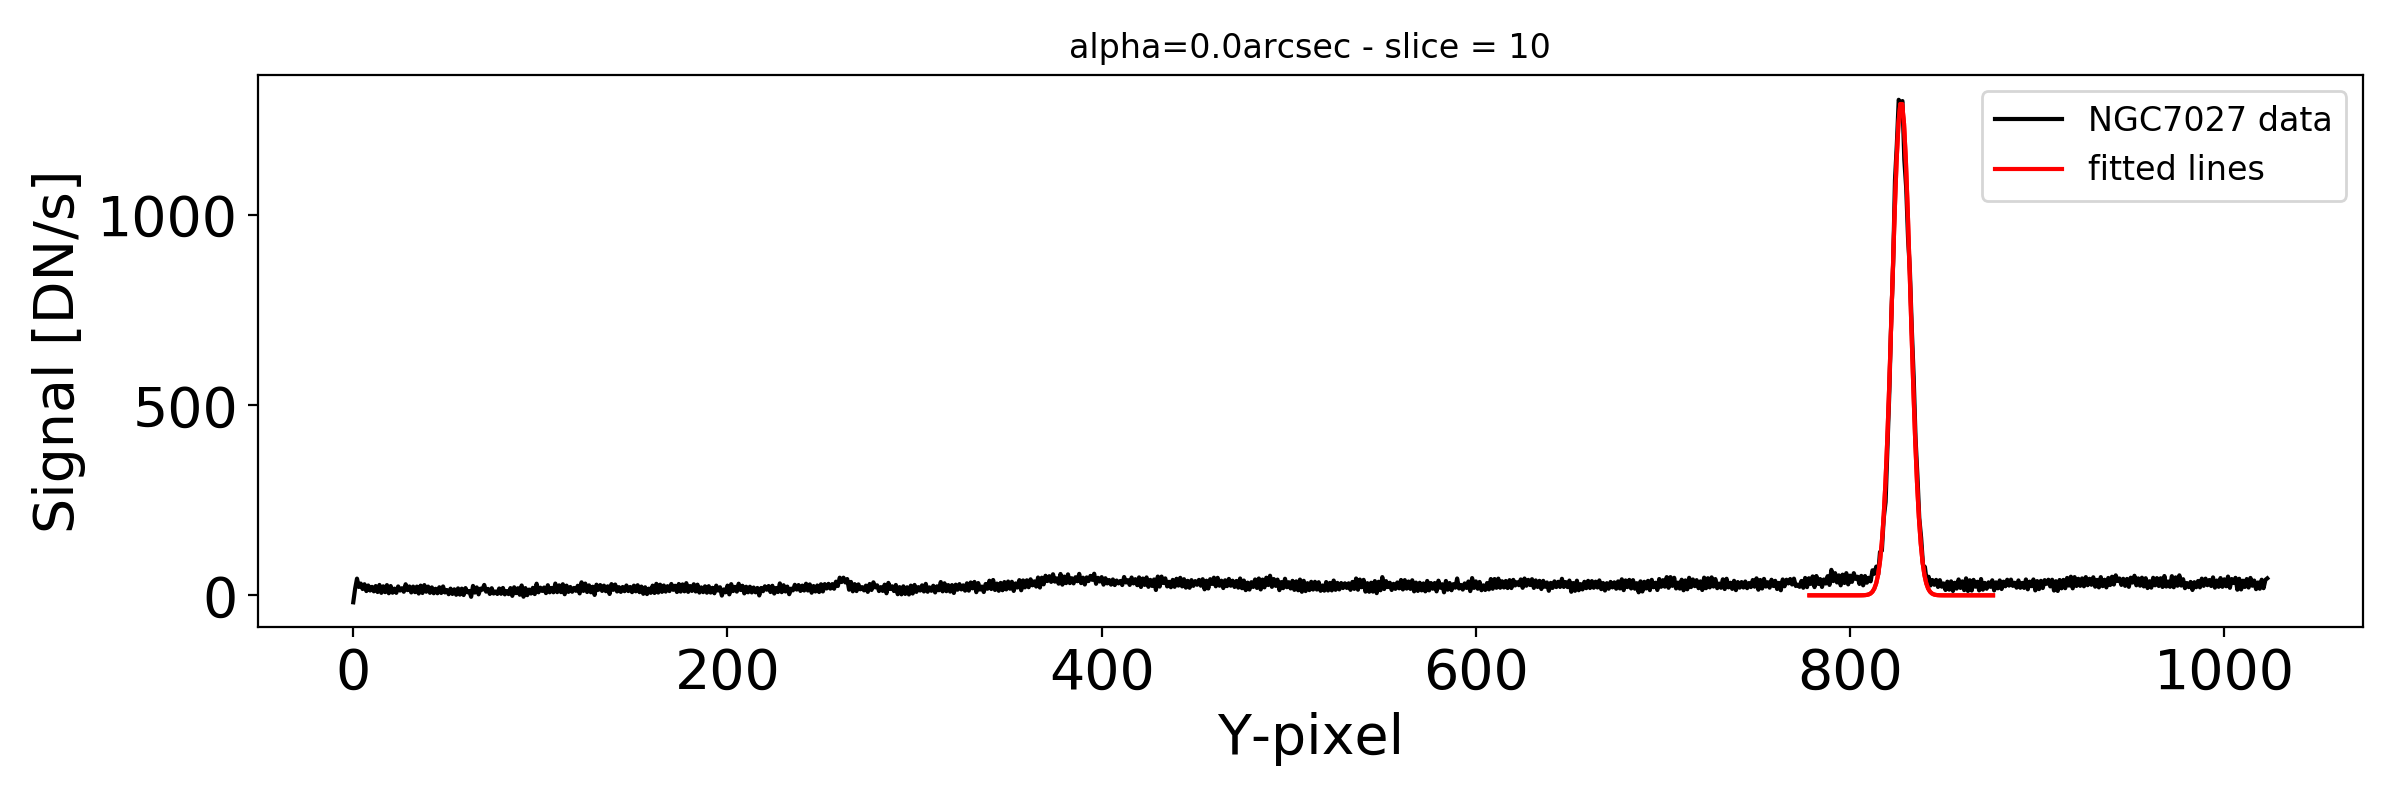

In [31]:
if band == '1A':
    # load spectrum from desired location and carry-out analysis
    spectrum = source_slope[ypos,xpos]

    peaks = funcs.find_peaks(spectrum, thres=0.8, min_dist=5)

    plt.figure(figsize=(12,4))
    plt.plot(spectrum,'k')
    plt.plot(peaks,spectrum[peaks],'ro')
    plt.xlabel('Detector x-coordinate [pixel]',fontsize=20)
    plt.ylabel('Signal [DN/sec]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

    # fit_etalon_lines(np.arange(1024),spectrum,peaks,fit_func='skewed_voight',sigma0=3.5,f0=0.5,a0=0.1)
    fitparams,fiterrors,fitting_flag,range_ini,range_fin = funcs.fit_emission_lines(np.arange(det_dims[0]),spectrum,peaks,fit_func='skewnorm_func',sigma0=3.5,f0=0.5,a0=0.1)

    linecenter = funcs.get_linecenter(fitparams,fitting_flag)
    linefwhm   = funcs.get_FWHM(fitparams,fitting_flag)
    lineskew   = funcs.get_skewness(fitparams,fitting_flag)

    # Plot the fits
    plt.figure(figsize=(12,4))
    plt.plot(spectrum,'k',label='NGC7027 data')
    #plt.vlines(cutoffpix,0,25,linestyle='dashed',label='reference point')
    funcs.plot_etalon_fit(fitparams,fitting_flag)
    plt.xlabel('Y-pixel',fontsize=20)
    plt.ylabel('Signal [DN/s]',fontsize=20)
    plt.title("alpha={}arcsec - slice = {}".format(str(alpha_pos),islice))
    plt.tick_params(axis='both',labelsize=20)
    plt.legend(loc='upper right',fontsize=12)
    plt.tight_layout()
    
    cutoffpix  = linecenter
    cutofflamb = 5.61048
    
elif band == '1B':
    from scipy.signal import savgol_filter
    # load spectrum from desired location and carry-out analysis
    spectrum = source_slope[ypos,xpos]
    
    # post-processing
    spectrum[np.isnan(spectrum)] = 0
    
    
    spectrum_grad = np.gradient(savgol_filter(spectrum[np.nonzero(spectrum)],21,3))
    spectrum_signs = np.sign(spectrum_grad)
#     spectrum_signs[:800] = 0
    spectrum_zerocrossing = np.where(np.abs(np.diff(spectrum_signs)) == 2)[0]
    
    # compute gradients and slopes
    x0 = spectrum_zerocrossing[0]
    x1 = np.arange(len(spectrum))[spectrum_zerocrossing[0]+1]
    y0 = spectrum_grad[spectrum_zerocrossing[0]]
    y1 = spectrum_grad[spectrum_zerocrossing[0]+1]
    a = (y1-y0)/(x1-x0)
    cutoffpix = (-y0/a) + x0
    
    plt.figure(figsize=(12,4))
    plt.plot(spectrum)
    plt.plot()
    plt.vlines(cutoffpix,spectrum.min(),spectrum.max())
    plt.ylim(0)
    plt.tight_layout()

In [24]:
# sel_wavl = (wavl>=funcs.mrs_aux(band)[3][0]) & (wavl<=funcs.mrs_aux(band)[3][1])
# wavl,spectrum = wavl[sel_wavl],spec[sel_wavl]

# peaks = funcs.find_peaks(spectrum, thres=0.8, min_dist=5)

# plt.figure(figsize=(5,4))
# plt.plot(wavl,spectrum)
# plt.plot(wavl[peaks],spectrum[peaks],'ro')
# plt.xlabel('Detector x-coordinate [pixel]',fontsize=12)
# plt.ylabel('Signal [DN/sec]',fontsize=12)
# plt.tight_layout()

# fitparams,fiterrors,fitting_flag,range_ini,range_fin = funcs.fit_emission_lines(wavl,spectrum,peaks,fit_func='skewed_voight',sigma0=0.01,f0=0.5,a0=0.1)
# A,mu,sigma,f0,a0 = fitparams[0]

# # Plot the fits
# plt.figure(figsize=(12,5))
# plt.plot(wavl,spectrum,'k',label='NGC7027 data')
# plt.plot(np.linspace(wavl[0],wavl[-1],5000),funcs.skewed_voight(np.linspace(wavl[0],wavl[-1],5000),*fitparams[0]),'r',label='Fit')
# plt.xlabel('Y-pixel',fontsize=20)
# plt.ylabel('Signal [DN/s]',fontsize=20)
# plt.title("alpha={}arcsec - slice = {}".format(str(alpha_pos),islice))
# plt.tick_params(axis='both',labelsize=20)
# plt.legend(loc='upper left',fontsize=12)
# plt.tight_layout()

# print popt

In [32]:
print 'YANNIS Reference wavelength: {} micron'.format(round(cutofflamb,3))
print 'YANNIS Reference pixel: {} pix'.format(round(cutoffpix,3))

yan_ref = np.array([cutofflamb,cutoffpix])

YANNIS Reference wavelength: 5.61 micron
YANNIS Reference pixel: 827.349 pix


In [12]:
# save output
save_file = open('data/Band'+str(band)+'_{}_refslice'.format(usedfilter)+str(islice)+'_alpha'+str(alpha_pos)+'_refpoint_'+user+'.txt', 'w')
save_file.write('# Band '+str(band)+'   Filter {}   RefSlice '.format(usedfilter)+str(islice)+'\n')
save_file.write('# Distortion map version 06.04.00 - date '+str(date.today())+'\n')
save_file.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
save_file.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
save_file.write('# Band'+str(band)+'_{}_refslice'.format(usedfilter)+str(islice)+'_alpha'+str(alpha_pos)+'\n')
save_file.write('\n')
save_file.write('# Reference Wavelength  Reference pixel (pix)\n')

if user == 'yannis':
    save_file.write(str(yan_ref[0])+'  '+str(yan_ref[1]))
elif user == 'alvaro':
    save_file.write(str(alo_ref[0])+'  '+str(alo_ref[1]))
save_file.close()